# Import des Netzwerks für das Modell

### Einrichtung

In [138]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math
import random

import pypsa

%matplotlib inline

## Setup

Setting up all the network's main components

All of the data is taken from another thesis, written at the same chair at TU Berlin as this one. The data is provided in the form of excel-files and is read using methods from pandas.

### Variables

In [139]:
nw = pypsa.Network()

In [140]:
nw.set_snapshots([p+672 for p in range(876)])
# snap_num = len(nw.snapshots)

In [141]:
cur_path = r"C:\Users\janni\OneDrive\TU Berlin\4 - Abschlussarbeiten\01 - Bachelorarbeit\modell\data\\"

In [142]:
marginal_costs_carrier = {"Erdgas":20,
                          "Braunkohle":50,
                          "Steinkohle": 40,
                          "Wind":5}

## Data Import

In [143]:
mapGermany_file = pd.ExcelFile(cur_path + "map_cities.xlsx")
mapAbroad_file = pd.ExcelFile(cur_path + "map_countries.xlsx")

fleet_file = pd.read_excel(cur_path + "power_grid_mapping_generator_fleet.xlsx", sheet_name="fleet_fuel", header=0, usecols="B:D")
# wind_file = pd.read_excel(cur_path + "Stromlast und Windeinspeisung.xlsx", sheet_name="Tabelle1", index_col=0, header=3, usecols="A:F")
demand_file = pd.read_excel(cur_path + "DE Realisierter Stromverbrauch 2017.xlsx", sheet_name="mapping_demand", index_col=0, header=0, usecols="A:J")
wind_dispatch_file = pd.read_excel(cur_path + "DE Realisierte Erzeugung 2017.xlsx", sheet_name="mapping_wind", index_col=0, header=0, usecols="A:C")

### Setup within Germany

In [144]:
df_buses = pd.read_excel(mapGermany_file, sheet_name="buses", header=0, usecols="B:D")
df_lines = pd.read_excel(mapGermany_file, sheet_name="lines", header=0, usecols="B:D")

### Setup abroad

In [145]:
df_countries = pd.read_excel(mapAbroad_file, sheet_name="buses", header=0, usecols="B:D")
df_countries_lines = pd.read_excel(mapAbroad_file, sheet_name="lines", header=0, usecols="B:D")
df_buses = df_buses.append(df_countries).reset_index(drop=True)
df_lines = df_lines.append(df_countries_lines).reset_index(drop=True)

Calculating the length of each line by Pythagoras.
The factor enables converting the distance in lattitude/longitude to kilometers

In [146]:
df_lines["length"] = 0
df_lines["x"]=0.0001
df_lines["s_nom"]= 1000
factor_coords_to_km = 111

for i in range(len(df_lines)):
    x_val = df_buses["x"][df_lines["bus0"][i]] - df_buses["x"][df_lines["bus1"][i]]
    y_val = df_buses["y"][df_lines["bus0"][i]] - df_buses["y"][df_lines["bus1"][i]]
    df_lines.at[i, "length"] = (math.sqrt(x_val**2 + y_val**2) * factor_coords_to_km)

In [147]:
pypsa.io.import_components_from_dataframe(nw, df_buses, "Bus")
pypsa.io.import_components_from_dataframe(nw, df_lines, "Line")

## Map topography

(<matplotlib.collections.PathCollection at 0x20438cbc2b0>,
 <matplotlib.collections.LineCollection at 0x204315e4780>)

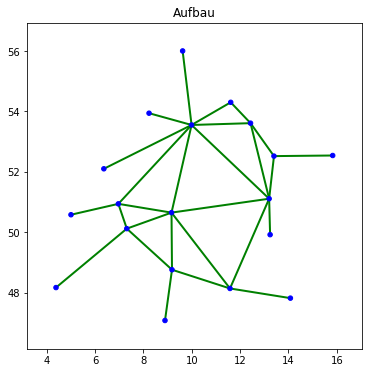

In [148]:
fig,ax=plt.subplots(1,1)
fig.set_size_inches(6,6)

nw.plot(bus_sizes=20, title="Aufbau")

## Components

### Generators

In [149]:
fleet_file.rename(columns={"fuel":"carrier",
                           "capacity[MW]":"p_nom"}, inplace=True)
fleet_file["committable"] = True

In [150]:
fleet_file["bus"] = 0
fleet_file["marginal_cost"] = 0

for j in range(len(fleet_file)):
    # find index of "Bundesland" of each generator
    indices = [i for i, s in enumerate(nw.buses.name) if fleet_file["state"][j] in s]
    fleet_file.at[j, "bus"] = indices[0]
    fleet_file.at[j, "marginal_cost"] = marginal_costs_carrier[fleet_file.iloc[j]["carrier"]]

In [151]:
pypsa.io.import_components_from_dataframe(nw, fleet_file, "Generator")

In [153]:
# Name of each Generator is a combination of state and carrier name (e.g. "Berlin Erdgas")
gen_names = ["{0} {1}".format(s, c) for s, c in zip(fleet_file["state"], fleet_file["carrier"])]

### Wind Energy

In [154]:
p_wind_generators = [[], []]

for i in range(2):
    # grab each column from wind df
    tmp = wind_dispatch_file.iloc[:, i].tolist()
    # take datapoints corresponding to timestamps in nw.snapshots
    p_wind_generators[i] = [tmp[i] for i in nw.snapshots.tolist()]

The nominal power of the generators was set to one because PyPSA internally multiplies p_nom with each value from p_min_pu and p_max_pu to get the dispatched power. Setting p_nom to one offers the possibility to leave the provided data as it is (in MWh).

In [155]:
nw.add("Generator", name="Offshore Nordsee",
       bus=17,
       carrier="Wind",
       p_nom=1,
       marginal_cost=marginal_costs_carrier["Wind"],
       # p_min_pu and p_max_pu have to be the same to ensure fixed amount of dispatched power
       p_min_pu=p_wind_generators[0],
       p_max_pu=p_wind_generators[0],
       committable=False)

nw.add("Generator", name="Offshore Ostsee",
       bus=18,
       carrier="Wind",
       p_nom=1,
       marginal_cost=marginal_costs_carrier["Wind"],
       # p_min_pu and p_max_pu have to be the same to ensure fixed amount of dispatched power
       p_min_pu=p_wind_generators[1],
       p_max_pu=p_wind_generators[1],
       committable=False)

### Attaching Loads

In [156]:
for i in range(8):
    demand_data_real = demand_file.iloc[:, i]
    nw.add("Load",
           "myload{0}".format(i),
           bus=i,
           # take datapoints corresponding to timestamps in nw.snapshots
           p_set=[demand_data_real[i] for i in nw.snapshots.tolist()])

## Linear Optimal Power Flow (incl. unit commitment for generators)

In [157]:
nw.lopf(solver_name="gurobi")

INFO:pypsa.pf:Slack bus for sub-network 0 is 0
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x99865
  Lower bound: 245905377.5
  Upper bound: 245905377.5
  Number of objectives: 1
  Number of constraints: 146293
  Number of variables: 99865
  Number of binary variables: 28908
  Number of integer variables: 28908
  Number of continuous variables: 70957
  Number of nonzeros: 283825
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: 

('ok', 'optimal')

## Visualization

In [158]:
gen_outs = nw.generators_t.p
# No negative values for plotting
gen_outs[gen_outs < 0] = 0
power_by_carrier = gen_outs.groupby(nw.generators.carrier, axis=1).sum()

In [159]:
graph_colors = {"Erdgas":"orange",
                "Braunkohle":"brown",
                "Steinkohle":"black",
                "Wind":"blue"}

col_order = ["Wind", "Erdgas", "Steinkohle", "Braunkohle"]

In [160]:
# Rename columns for graph information
for i in range(len(gen_names)):
    gen_outs.rename(columns={("{}".format(i)):("{}".format(gen_names[i]))}, inplace=True)

Line graph to display the dispatched amount of energy per plant

Text(0,0.5,'MW')

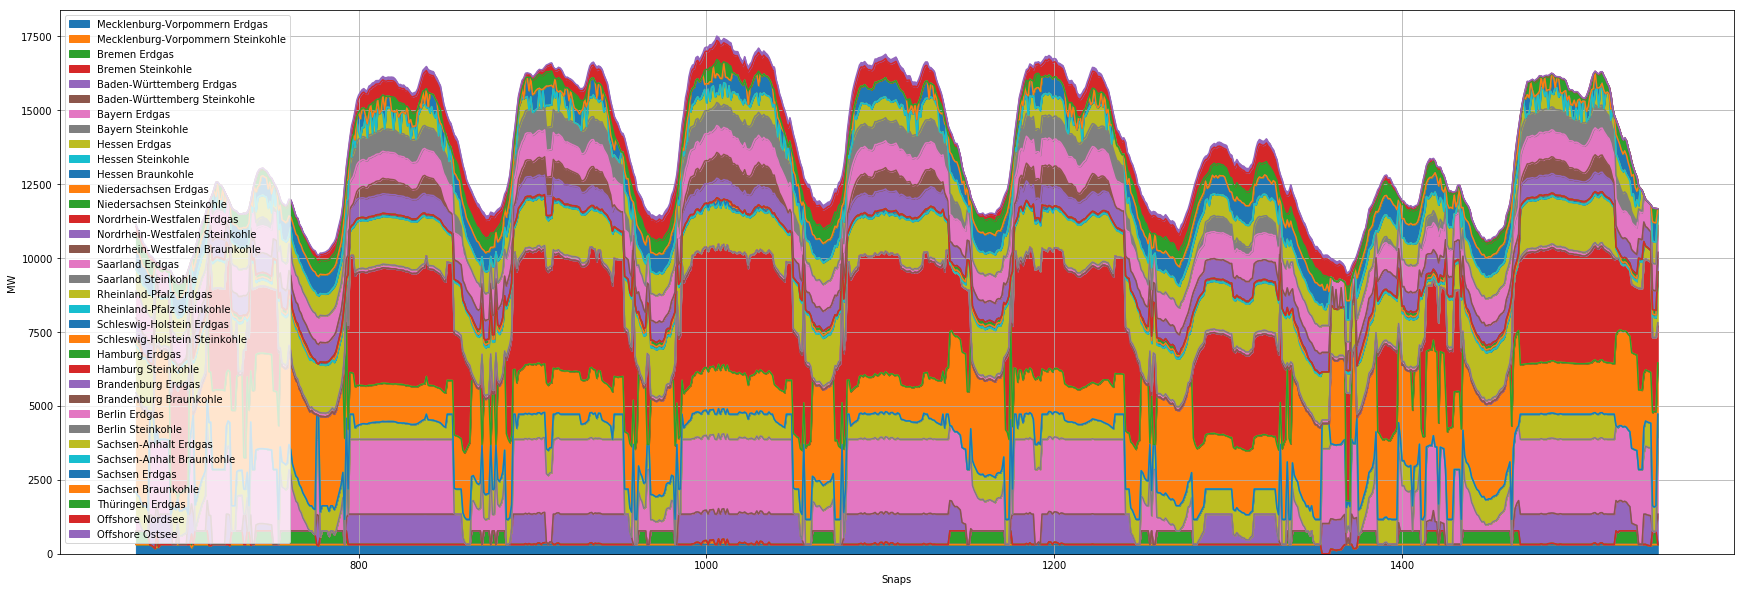

In [161]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(30,10)

(gen_outs).plot(kind="area",ax=ax, grid=True)

ax.set_xlabel("Snaps")
ax.set_ylabel("MW")

Text(0,0.5,'MW')

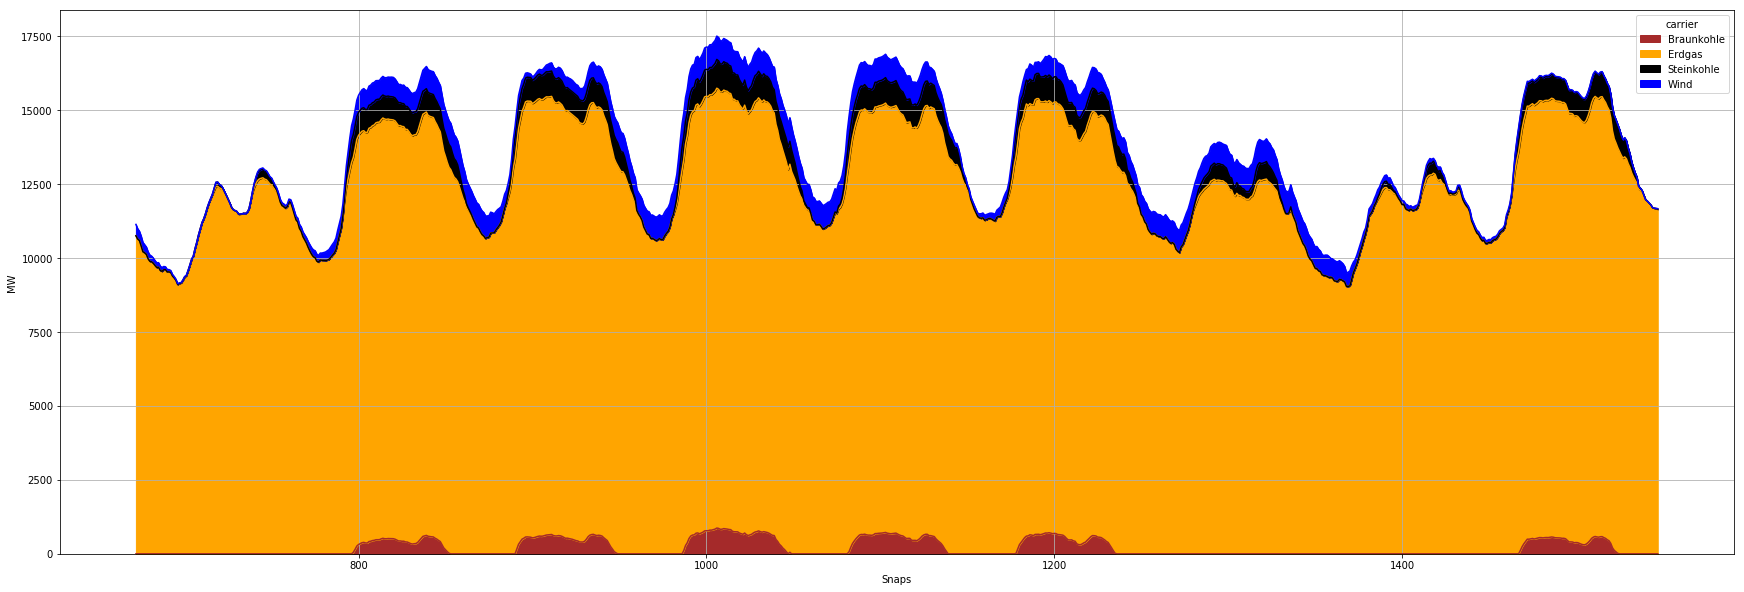

In [164]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(30,10)

power_by_carrier.plot(kind="area",ax=ax, grid=True, color=[graph_colors[i] for i in power_by_carrier.columns])

ax.set_xlabel("Snaps")
ax.set_ylabel("MW")